# Hybrid model: Hanazaki
***

**Author:** Chus Casado Rodríguez<br>
**Date:** 03-10-2024<br>


In [25]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pickle
from pathlib import Path
from tqdm import tqdm
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cf

from neuralhydrology.utils.config import Config
from neuralhydrology.datasetzoo import get_dataset
from neuralhydrology.datautils.utils import load_scaler
from neuralhydrology.modelzoo import get_model
from neuralhydrology.evaluation.plots import boxplot_performance, map_results, boxplot_parameters, lineplot_timeseries

In [26]:
from utils import *

## Configuration

In [27]:
MODEL_PATH = Path('/eos/jeodpp/home/users/casadje/models/ResOpsUS/hybrid_model/')
run_dir = MODEL_PATH / 'hanazaki' / 'storage' / 'test_static_0210_100205' # 'benchmark_2709_092431'

# read configuration file
cfg = Config(run_dir / 'config.yml')

## Data

### Attributes

In [28]:
# load list of reservoirs
reservoirs = sorted(pd.read_csv(cfg.test_basin_file, header=None)[0].tolist())

# load attributes
attributes = pd.concat([pd.read_csv(file, index_col='GRAND_ID') for file in (cfg.data_dir / 'attributes').glob('*.csv')], 
                       axis=1,
                       join='outer')
attributes.index.name = 'id'
attributes = attributes.loc[reservoirs, cfg.static_attributes]

print('no. reservoirs in the attribute tables:', attributes.shape[0])

no. reservoirs in the attribute tables: 118


### Time series

In [29]:
# load time series
dynamic_vars = cfg.dynamic_inputs + cfg.dynamic_conceptual_inputs + cfg.target_variables 
if 'storage_norm' not in cfg.target_variables:
    dynamic_vars += ['storage_norm']
if 'outflow_norm' not in cfg.target_variables:
    dynamic_vars += ['outflow_norm']
timeseries = {ID: xr.open_dataset(cfg.data_dir / 'time_series' / f'{ID}.nc').to_pandas()[dynamic_vars] for ID in reservoirs}
# trim time series to the test period
with open(cfg.per_basin_test_periods_file, 'rb') as file:
    periods = pickle.load(file)
periods = {ID: dct for ID, dct in periods.items() if int(ID) in reservoirs}
for ID, ts in timeseries.items():
    start, end = [periods[str(ID)][x][0] for x in ['start_dates', 'end_dates']]
    ts = ts.loc[start:end]

# # plot time series
# for ID, ts in timeseries.items():
#     start, end = [ls[0] for key, ls in periods[str(ID)].items()]
#     fig, ax = plt.subplots(nrows=2, figsize=(15, 6), sharex=True)
#     ts.loc[start:end, ['inflow_norm', 'outflow_norm']].plot(ax=ax[0], lw=.8);
#     ts.loc[start:end, ['storage_norm']].plot(ax=ax[1], lw=.8)
#     ax[0].set_title(ID)
#     ax[1].set(ylim=(-.02, 1.02),
#               ylabel='storage (-)',
#               );
#     plt.savefig(cfg.data_dir / 'plots' / f'{ID:04}.jpg')

## Results

### Performance

best epoch:	1
NSE train:	-5.159
NSE validation:	-16.364


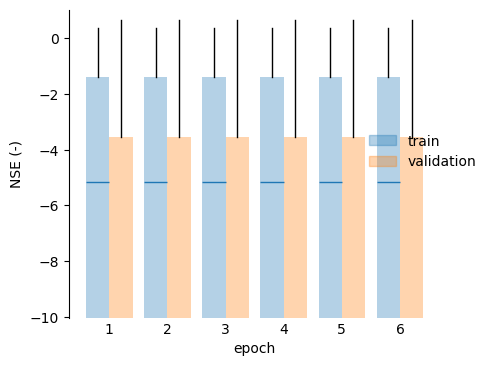

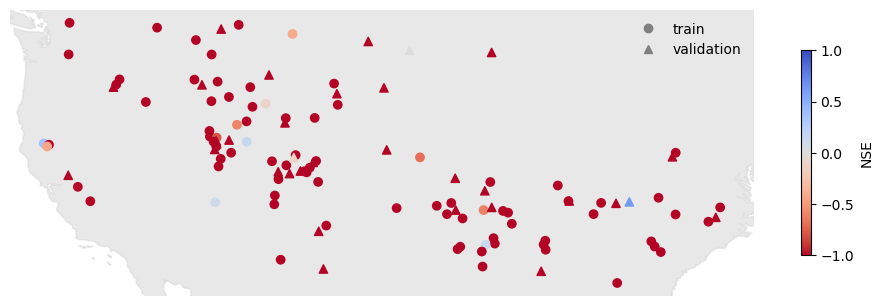

In [30]:
metric = cfg.metrics[0]

# performance of each reservoir, sample and epoch
performance = {sample: [] for sample in ['train', 'validation']}#, 'test']}
for sample, perf_list in performance.items():
    for epoch in range(1, cfg.epochs + 1):
        try:
            aux = pd.read_csv(run_dir / sample / f'model_epoch{epoch:03}' / f'{sample}_metrics.csv',
                              index_col='basin').squeeze()
            aux.name = epoch
            perf_list.append(aux)
        except Exception as e:
            print(e)
performance = {sample: pd.concat(perf_list, axis=1) for sample, perf_list in performance.items()}

# best epoch
best_epoch = performance['validation'].median(axis=0).idxmax()
# best_epoch = performance['validation'].apply(ECDF_AUC).idxmax()
print(f'best epoch:\t{best_epoch}')
for sample, df in performance.items():
    print('{0} {1}:\t{2:.3f}'.format(metric, sample, df[best_epoch].median()))
    # print('{0} {1}:\t{2:.3f}'.format(metric, sample, ECDF_AUC(df[best_epoch])))

# define sample and performance of each reservoir
for sample, df in performance.items():
    attributes.loc[df.index, 'sample'] = sample
    attributes.loc[df.index, metric] = df[best_epoch]

# add performance to the attributes
cols = [f'{metric}_{sample}' for sample in performance.keys()]
if len(attributes.columns.intersection(cols)) == 0:
    attributes = pd.concat((attributes, pd.DataFrame({f'{metric}_{sample}': df[best_epoch] for sample, df in performance.items()})), axis=1)

# boxplot performance
boxplot_performance(
    cfg,
    performance,
    ylim=(-10.02, 1.02),
    save=run_dir / 'performance_boxplot.jpg'
)

# map performance
map_results(
    attributes.LON,
    attributes.LAT,
    attributes[metric],
    attributes['sample'],
    save=run_dir / f'performance_map_epoch{best_epoch:03}'
)

### Evaluate

I run the evaluation on all the reservoirs to extract not only the target variables, but also the parameters of the conceptual model.

In [31]:
weights = {}
for epoch in range(1, cfg.epochs + 1):
    weights[epoch] = torch.load(run_dir / f'model_epoch{epoch:03}.pt',)

In [32]:
matrix = 'lstm.weight_hh_l0'
torch.all(torch.isclose(weights[6][matrix], weights[4][matrix]))

tensor(False, device='cuda:0')

In [33]:
weights[6].keys()

odict_keys(['lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'linear.weight', 'linear.bias'])

In [34]:
# get the hybrid model: LSTM + LinearReservoir
model = get_model(cfg).to(cfg.device)
print(model)
print('device:', next(model.parameters()).device)

# load model states
weights = torch.load(run_dir / f'model_epoch{best_epoch:03}.pt',)
model.load_state_dict(weights)

# load scaler
scaler = load_scaler(run_dir)

# evaluate
results = {sample: {} for sample in ['train', 'validation']}
for sample, results_sample in results.items():
    # load sample data
    dataset = get_dataset(cfg,
                          is_train=False,
                          period=sample,
                          scaler=scaler)
    basins = [int(basin) for basin in dataset.basins]

    # run evaluation basin per basin
    pbar = tqdm(dataset.basins, desc=f'# {sample}')
    for basin in pbar:
        # load dataset
        ds = get_dataset(cfg=cfg,
                         is_train=False,
                         period=sample,
                         basin=basin,
                         # additional_features=self.additional_features,
                         # id_to_int=self.id_to_int,
                         scaler=scaler)

        # setup data loader
        loader = DataLoader(ds,
                            batch_size=cfg.batch_size,
                            num_workers=0,
                            collate_fn=ds.collate_fn)
        
        # evaluate
        results_sample[basin] = evaluate(cfg, model, loader)

HybridModel(
  (embedding_net): InputLayer(
    (statics_embedding): Identity()
    (dynamics_embedding): Identity()
  )
  (lstm): LSTM(28, 256)
  (conceptual_model): HanazakiStatic()
  (linear): Linear(in_features=256, out_features=5, bias=True)
)
device: cuda:0


# train: 100% 85/85 [05:26<00:00,  3.84s/it]
# validation: 100% 33/33 [01:55<00:00,  3.49s/it]


In [35]:
# convert results to pandas.DataFrame
results_df = {sample: {} for sample in results}
for sample, results_sample in results.items():
    for basin, dct in results_sample.items():
        # define date index
        start, end = [periods[basin][f'{x}_dates'][0] for x in ['start', 'end']]
        dates = pd.date_range(start, end, freq='1D')
                
        # concatenate time series
        df = pd.concat((
            pd.Series(dct['inflow'].numpy()[:, -1, 0], index=dates, name='inflow'),
            # pd.Series(dct['parameters'].numpy()[:, -1], index=dates, name='T'),
            pd.Series(dct['storage'].numpy()[:, -1], index=dates, name='storage'),
            # pd.Series(results[basin]['outflow'].numpy()[:, -1, 0], index=dates, name='outflow'),
        ),
            axis=1
        )
        if 'outflow' in dct:
            df = pd.concat((
                df,
                pd.Series(dct['outflow'].numpy()[:, -1, 0], index=dates, name='outflow'),
            ),
            axis=1
        )
        
        df_pars = pd.concat([pd.Series(parvalues[:, -1].numpy(), index=dates, name=parname) for parname, parvalues in dct['parameters'].items()], axis=1)
        df = pd.concat([df, df_pars], axis=1)
        results_df[sample][basin] = df

#### Parameters

In [36]:
# add the median of the estimated parameter to the attributes table
parnames = list(model.conceptual_model.parameter_ranges)
for par in parnames:
    attributes[par] = pd.Series({int(basin): df[par].median(skipna=True) for sample, dct in results_df.items() for basin, df in dct.items()}, name=par)

In [37]:
# export median value
PATH_OUT = run_dir / sample / f'model_epoch{best_epoch:03}'
for sample in attributes['sample']:
    mask = attributes['sample'] == sample
    attributes[mask][parnames].to_csv(run_dir / sample / f'model_epoch{best_epoch:03}' / f'{sample}_parameters.csv')

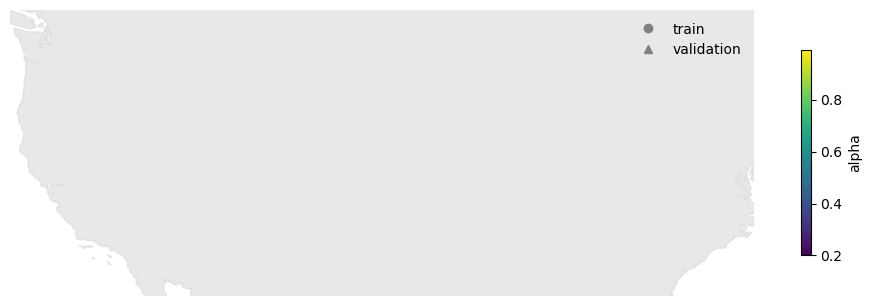

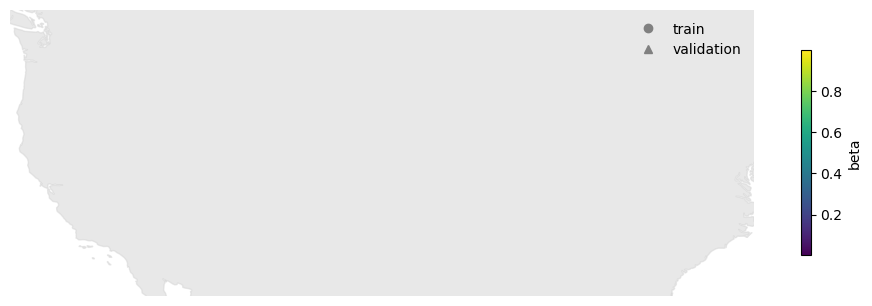

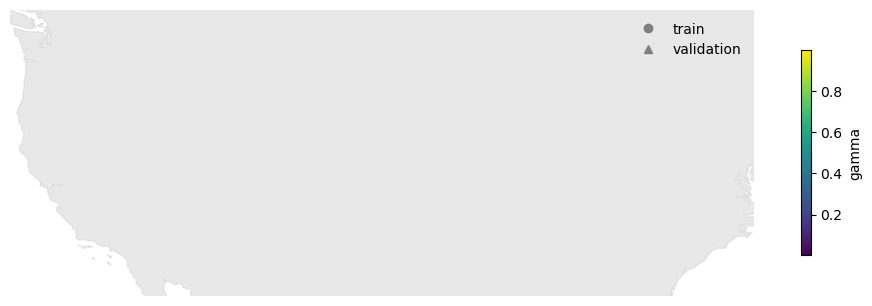

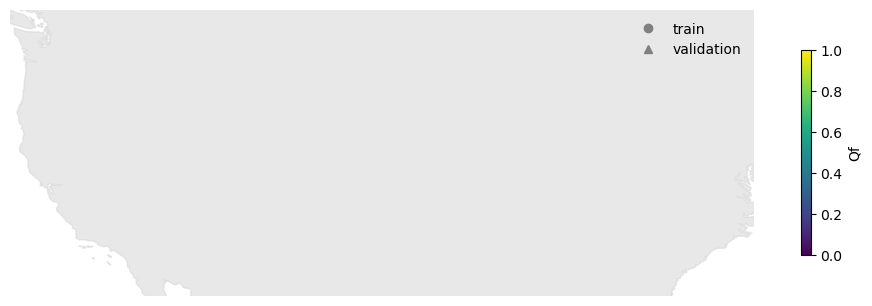

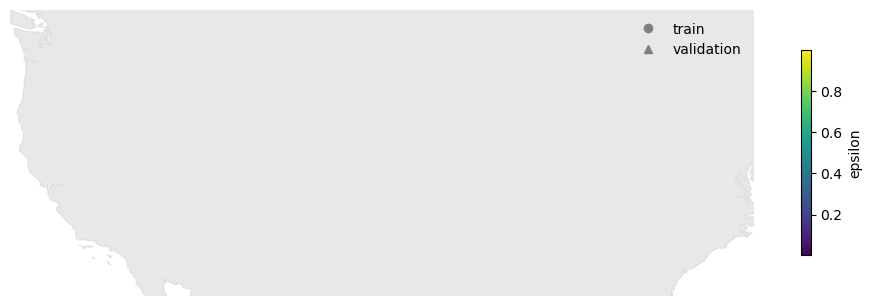

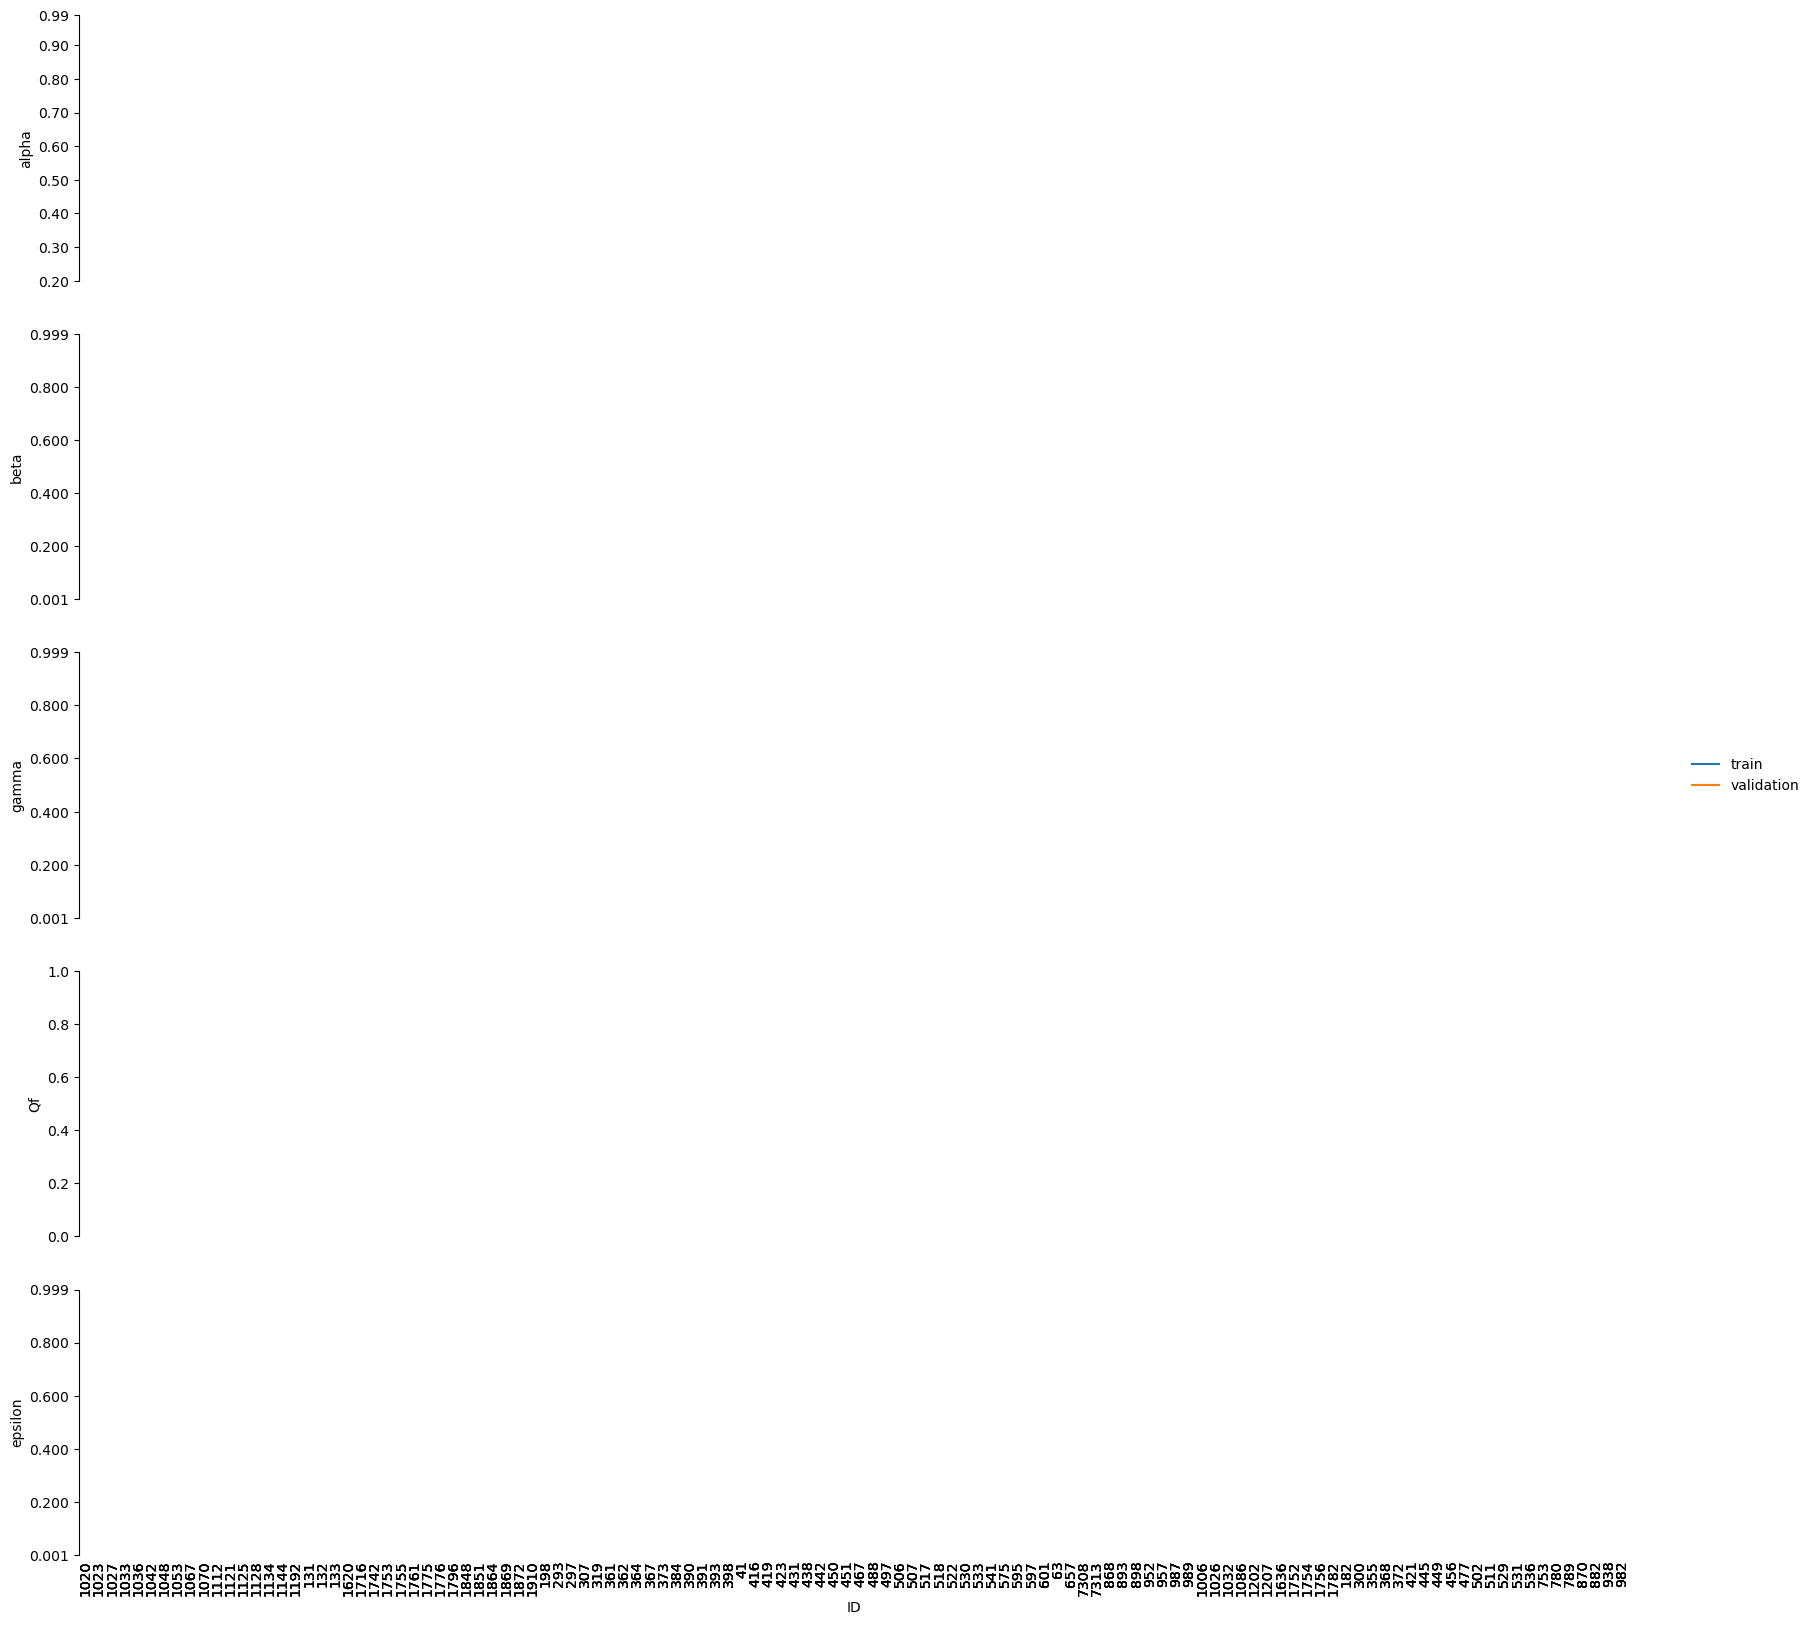

In [38]:
# map fitted parameter
for par in parnames:
    map_results(
        attributes.LON,
        attributes.LAT,
        attributes[par],
        attributes['sample'],
        clim=model.conceptual_model.parameter_ranges[par],
        cmap='viridis',
        save=run_dir / f'parameter_{par}_map_epoch{best_epoch:03}.jpg'
    )
    
# boxplot of simulated parameters
boxplot_parameters(
    results_df,
    model.conceptual_model.parameter_ranges,
    save=run_dir / f'parameter_boxplot_epoch{best_epoch:03}.jpg'
)

#### Time series

In [39]:
# plot simulated vs observed timeseries
for sample, dct in results_df.items():
    path_out = run_dir / sample / f'model_epoch{best_epoch:03}' / 'plots'
    path_out.mkdir(parents=True, exist_ok=True)
    for ID, df in dct.items():
        lineplot_timeseries(
            cfg,
            sim=df,
            obs=timeseries[int(ID)],
            parameter_ranges=model.conceptual_model.parameter_ranges,
            xlim=[periods[str(ID)][f'{dt}_dates'][0] for dt in ['start', 'end']],
            title=ID,
            save=path_out / f'{ID}.jpg'
        )

***

In [ ]:
target = cfg.target_variables[0]
results_df['validation']['1006'][target.split('_')[0]]

In [ ]:
timeseries[1006][cfg.target_variables[0]]

In [ ]:
performance['validation'].loc[1006]

In [ ]:
best_epoch

In [ ]:
kge, alpha, beta, r = KGE(obs=timeseries[1006][cfg.target_variables[0]],
                          sim=results_df['validation']['1006'][target.split('_')[0]])
kge, alpha, beta, r

***

In [ ]:
sample = 'train'
ID = performance[sample][best_epoch].idxmax()
# ID = 300 #445 # 372 # 1032

ID, performance[sample][best_epoch].max()

#### Parameters

In [ ]:
par = results[sample][str(ID)]['parameters'].numpy()
print(par.shape)

vmin, vmax = model.conceptual_model.parameter_ranges['T']
fig, ax = plt.subplots()#figsize=(15, 3))
im = ax.imshow(np.transpose(par), vmin=vmin, vmax=vmax)
ax.set(
    xlabel='date',
    ylabel='warmup (d)'
)
# ax.set_xticklabels([dt.date() for dt in dates[::1000]])
fig.colorbar(im, shrink=.333, label='parameter T (d)', orientation='horizontal');#, pad=.35);

In [ ]:
model.conceptual_model.device

In [ ]:
# fractin filled, i.e., normalised storage
ff = torch.tensor(0.65,
                  dtype=torch.float32,
                  device='cuda'
                 )#.repeat(x_conceptual.shape[0])
print(ff.shape)

# storage limits
FFc = torch.tensor(0.1,
                   dtype=torch.float32,
                   device='cuda',
                   requires_grad=False)
print(FFc.shape)

if ff < FFc:
    print('hola')
else:
    print('adiós')

In [ ]:
FF = torch.tensor([0.1, 0.2, 0.3], dtype=torch.float32, device='cuda', requires_grad=True)

In [ ]:
# Create an empty tensor with the same shape as FF
zeros = torch.zeros_like(FF, requires_grad=FF.requires_grad)

In [ ]:
zeros.dtype, zeros.device, zeros.requires_grad

#### Outflow

In [ ]:
if 'outflow' in results[sample][str(ID)]:
    out = results[sample][str(ID)]['outflow'].numpy()[:,:,0]
    print(out.shape)

    im = plt.imshow(np.transpose(out), vmin=0)
    plt.colorbar(im, shrink=.333, label='outflow (-)', orientation='horizontal');

#### Storage

In [ ]:
state = results[sample][str(ID)]['storage'].numpy()
print(state.shape)
im = plt.imshow(np.transpose(state), vmin=0, vmax=1)
plt.colorbar(im, shrink=.333, label='storage (-)', orientation='horizontal');

In [ ]:
dates = pd.date_range(*[periods[str(ID)][f'{dt}_dates'][0] for dt in ['start', 'end']])

fig, ax = plt.subplots(nrows=3, figsize=(15, 6), sharex=True)
lw = .3
for n, i in enumerate(np.linspace(0, state.shape[1] - 1, 3)):
    # c = 'k' if i == out.shape[1] - 1 else f'C{n}'
    c = f'C{abs(2 - n)}'
    if 'outflow_norm' in cfg.target_variables:
        ax[0].plot(pd.Series(out[:, int(i)], index=dates), c=c, lw=lw*(n+1), label=f'warmup={i:.0f}')
    ax[1].plot(pd.Series(state[:, int(i)], index=dates), c=c, lw=lw*(n+1), label=f'warmup={i:.0f}')
    ax[2].plot(pd.Series(par[:, int(i)], index=dates), c=c, lw=lw*(n+1), label=f'warmup={i:.0f}')

# observed
ax[0].plot(timeseries[int(ID)].loc[dates, 'outflow_norm'], lw=lw*(n+1), c='k', zorder=0, label='obs')
ax[1].plot(timeseries[int(ID)].loc[dates, 'storage_norm'], lw=lw*(n+1), c='k', zorder=0, label='obs')
    
ax[0].set(xlim=(dates[0], dates[-1]),
          ylim=(0, None),
          ylabel='outflow (-)')
ax[1].set(ylim=(-.05, 1.05),
          ylabel='storage (-)')
ax[2].set(ylim=model.conceptual_model.parameter_ranges['T'],
          ylabel='T (days)')
ax[-1].set_xlabel('date')

# ax[-1].set_xlim((pd.Timestamp(2000, 1, 1), pd.Timestamp(2001, 1, 1)))

fig.legend(*ax[1].get_legend_handles_labels(), frameon=False, loc=5, bbox_to_anchor=[.9, .33, .15, .33]);

***

#### Evaluation

In [ ]:
model.eval()
predictions = []
inflow = []
# obs = []
with torch.no_grad():
    for data in loader:
        # run the LSTM
        # concatenate dynamic and static variables
        x_s_expanded = data['x_s'].unsqueeze(1).expand(-1, data['x_d'].size(1), -1)
        x_concatenated = torch.cat((data['x_d'], x_s_expanded), dim=2).to(cfg.device)
        lstm_output, _ = model.lstm(x_concatenated)

        # run the FC
        linear_output = model.linear(lstm_output[:, cfg.warmup_period:, :])

        # run conceptual model
        x_conceptual = data['x_d_c'][:, cfg.warmup_period:, :]
        pred = model.conceptual_model(x_conceptual=x_conceptual.to(cfg.device),
                                      lstm_out=linear_output)
        inflow.append(x_conceptual)
        predictions.append(pred)

In [ ]:
model.conceptual_model.parameter_ranges

In [ ]:
{par: torch.cat([pred['parameters'][par] for pred in predictions], dim=0).detach().cpu() for par in model.conceptual_model.parameter_ranges}

In [ ]:
    pred = {
        'inflow': torch.cat(inflow, dim=0),
        'storage': torch.cat([pred['internal_states']['ff'] for pred in predictions], dim=0).detach().cpu(),
        'parameters': torch.cat([pred['parameters'] for pred in predictions], dim=0).detach().cpu()
    }

#### Hanazaki

In [ ]:
# get model parameters
parameters = model.conceptual_model._get_dynamic_parameters_conceptual(lstm_out=linear_output)

# initialize structures to store the information
states, out = model.conceptual_model._initialize_information(conceptual_inputs=x_conceptual)

# initialize constants
zero = torch.tensor(0.0, dtype=torch.float32, device=x_conceptual.device)
one = torch.tensor(1.0, dtype=torch.float32, device=x_conceptual.device, requires_grad=False)
eps = torch.tensor(1e-8, dtype=torch.float32, device=x_conceptual.device, requires_grad=False)

# inflow [batch_size,seq_length-warmup_period]
inflow = x_conceptual[:, :, 0].clone().to(cfg.device)
inflow = torch.where(torch.isnan(inflow), torch.zeros_like(inflow), inflow)

# fractin filled, i.e., normalised storage [batch_size]
ff = torch.tensor(model.conceptual_model.initial_states['ff'],
                  dtype=torch.float32,
                  device=cfg.device
                 ).repeat(x_conceptual.shape[0])

# constant parameters
FFf = torch.nanmean(parameters['alpha'])
FFe = FFf + (1 - FFf) * torch.nanmean(parameters['beta'])
FFn = FFf * torch.nanmean(parameters['gamma'])
FFc = torch.tensor(0.1, dtype=torch.float32, device=x_conceptual.device, requires_grad=False) # JCR: GloFAS default value. It should be different for each reservoir, though
# k = 1 # max(1 - 5 * (1 - FFf) / A, 0) # JCR: how to read the catchment area (A)?
k = torch.tensor(1, dtype=torch.float32, device=x_conceptual.device, requires_grad=False)
Qf = torch.nanmean(parameters['Qf'])
Qn = Qf * torch.nanmean(parameters['epsilon'])

# reservoir routine
for j in range(x_conceptual.shape[1]):

    # # time-varying parameters
    # FFf = parameters['alpha'][:,j]
    # FFe = FFf + (1 - FFf) * parameters['beta'][:,j]
    # FFn = FFf * parameters['gamma'][:,j]
    # Qf = parameters['Qf'][:,j]
    # Qn = Qf * parameters['epsilon'][:,j]

    # update storage
    ff = ff + inflow[:,j]

    # storage conditions
    mask_c = ff <= FFc                # conservative zone
    mask_n = (ff > FFc) & (ff <= FFf) # normal zone
    mask_f = (ff > FFf) & (ff <= FFe) # flood zone
    mask_e = ff > FFe                 # extreme zone
    # inflow condition
    mask_I = inflow[:,j] > Qf         # flood event

    # outflow
    outflow = torch.zeros_like(ff, requires_grad=ff.requires_grad)
    outflow = torch.where(mask_c, Qn * ff / FFf, outflow)
    outflow = torch.where((mask_n | mask_f) & ~mask_I, FFc / FFf * Qn + ((ff - FFc) / (FFe - FFc))**2 * (Qf - FFc / FFf * Qn), outflow)
    outflow = torch.where(mask_n & mask_I, FFc / FFf * Qn + (ff - FFc) / (FFf - FFc) * (Qf - FFc / FFf * Qn), outflow)
    outflow = torch.where(mask_f & mask_I, Qf + k * (ff - FFf) / (FFe - FFf) * (inflow[:,j] - Qf), outflow)
    outflow = torch.where(mask_e & ~mask_I, Qf, outflow)
    outflow = torch.where(mask_e & mask_I, inflow[:,j], outflow)
    # limit outflow so the final storage is between 0 and 1
    outflow = torch.max(torch.min(outflow, ff - FFc), ff - one + eps)

    # update storage
    ff = ff - outflow

    # store storage (and outflow)
    states['ff'][:, j] = ff
    out[:, j, 0] = outflow

In [ ]:
fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True)

ax[0].imshow(inflow.detach().cpu(), vmin=0)
ax[0].set_title('inflow')

ax[1].imshow(states['ff'].detach().cpu(), vmin=0, vmax=1)
ax[1].set_title('storage')

ax[2].imshow(out[:, :, 0].detach().cpu(), vmin=0)
ax[2].set_title('outflow');

In [ ]:
# first sample in the batch
fig, ax = plt.subplots(ncols=3, figsize=(13, 4), sharex=True, sharey=True)

ax[0].plot(inflow[0,:].detach().cpu())
ax[0].set_title('inflow')

ax[1].plot(states['ff'][0,:].detach().cpu())
ax[1].set_title('storage')

ax[2].plot(out[0,:, 0].detach().cpu())
ax[2].set_title('outflow');

fig.suptitle('First sample in the batch');

In [ ]:
FFf

In [ ]:
# prediction in the last timestep
fig, ax = plt.subplots(ncols=2, figsize=(9, 4), sharex=True, sharey=True)

ax[0].plot(inflow[:,-1].detach().cpu(), label='inflow')
ax[0].plot(out[:, -1, 0].detach().cpu(), label='outflow')
for flow_limit in [Qf, Qn]:
    try:
        ax[0].axhline(flow_limit.detach().cpu(), lw=.5, c='k', ls='--')
    except:
        ax[0].plot(flow_limit.detach().cpu(), lw=.5, c='k', ls='--')
ax[0].set_title('(in/out)flow')
ax[0].legend(frameon=False)

ax[1].plot(states['ff'][:,-1].detach().cpu())
for storage_limit in [FFe, FFf, FFn, FFc]:
    try:
        ax[1].axhline(storage_limit.detach().cpu(), lw=.5, c='k', ls='--')
    except:
        ax[1].plot(storage_limit.detach().cpu(), lw=.5, c='k', ls='--')
# ax[1].plot(FFe.detach().cpu(), lw=.5, c='k', ls='--')
# ax[1].plot(FFn.detach().cpu(), lw=.5, c='k', ls='--')
ax[1].set_title('storage')

# ax[2].plot(out[:, -1, 0].detach().cpu())
# ax[2].set_title('outflow');

fig.suptitle('Prediction in the last timestep of each sample');

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 3))

ax1.plot(states['ff'][:,-1].detach().cpu(), c='k')
ax1.set(ylim=(-.02, 1.02),
        ylabel='storage (-)')

ax2 = ax1.twinx()
ax2.plot(inflow[:,-1].detach().cpu())
ax2.plot(out[:, -1, 0].detach().cpu())
try:
    ax2.axhline(Qf.detach().cpu(), c='k', ls=':')
except:
    ax2.plot(Qf.detach().cpu(), c='k', ls=':')
ax2.set(ylim=(-.02, None),
        ylabel='flow (-)');

In [ ]:
Qf

In [ ]:
plt.imshow(out[:, :, 0].detach().cpu(), vmin=0);

In [ ]:
plt.imshow(states['ff'].detach().cpu(), vmin=0, vmax=1)

In [ ]:
plt.plot(ff.detach().cpu())

In [ ]:
plt.plot(outflow.detach().cpu())

In [ ]:
torch.isnan(ff).sum()

***